In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [50]:
# Utility Functions
def generate_colors(n):
    colors = []
    for i in range(n):
        ratio = i / max(n - 1, 1)

        r = max(0, min(1, abs(ratio * 6 - 3) - max(abs(ratio * 6 - 4) - 1, 0)))
        g = max(0, min(1, 1 - abs(ratio * 6 - 2)))
        b = max(0, min(1, 1 - abs(ratio * 6 - 4)))

        colors.append((r, g, b))
    return colors


In [51]:
def fetch_crypto_data_history(symbols, period="1y", interval="4h"):
    crypto_data = {}
    successfully_fetched = []

    for symbol in symbols:
        try:
            ticker = yf.Ticker(f"{symbol}-USD")
            data = ticker.history(period=period, interval=interval)

            if len(data) > 100:  # Ensure enough data for grid trading
                # Ambil tanggal hari ini - 2 hari
                cutoff_date = (pd.Timestamp.today() - timedelta(days=2)).tz_localize('UTC')

                # Filter data sampai cutoff_date
                data = data[data.index <= cutoff_date]

                crypto_data[symbol] = data
                successfully_fetched.append(symbol)
                print(f"Successfully fetched data for: {successfully_fetched}\n")
            else:
                print(f"Insufficient data for {symbol}, skipping...\n")

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}\n")

    return crypto_data

In [52]:
crypto_symbols = ["BTC", "ETH", 'SOL', 'BNB']
raw_crypto_data = fetch_crypto_data_history(crypto_symbols, period="1mo", interval="15m")

Successfully fetched data for: ['BTC']

Successfully fetched data for: ['BTC', 'ETH']

Successfully fetched data for: ['BTC', 'ETH', 'SOL']

Successfully fetched data for: ['BTC', 'ETH', 'SOL', 'BNB']



--- BTC ---
Data Shape : (2715, 7)
Date Range : 2025-09-26 to 2025-10-24
Zero Volume Days Detected: 439
--- ETH ---
Data Shape : (2715, 7)
Date Range : 2025-09-26 to 2025-10-24
Zero Volume Days Detected: 334
--- SOL ---
Data Shape : (2716, 7)
Date Range : 2025-09-26 to 2025-10-24
Zero Volume Days Detected: 877
--- BNB ---
Data Shape : (2716, 7)
Date Range : 2025-09-26 to 2025-10-24
Zero Volume Days Detected: 849


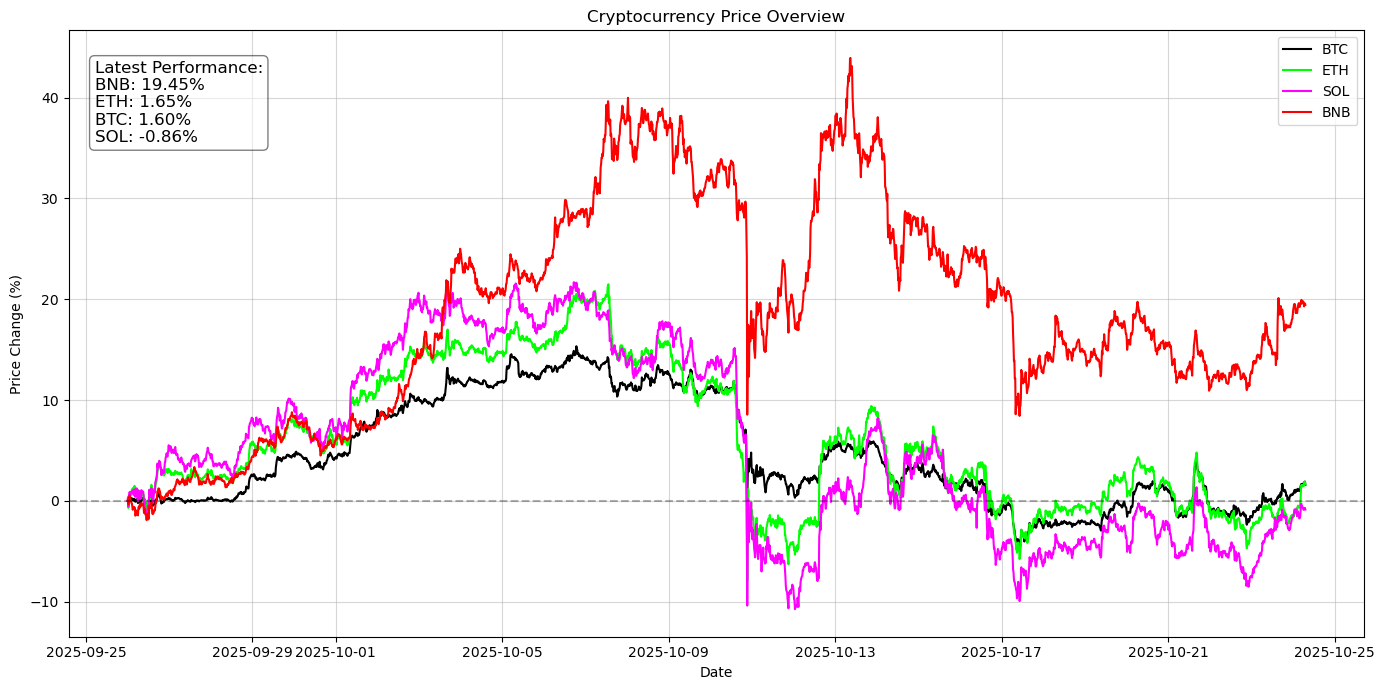

In [53]:
def crypto_data_overview(crypto_data):
    for symbol, data in crypto_data.items():
        print(f"--- {symbol} ---")
        print(f"Data Shape : {data.shape}")
        print(f"Date Range : {data.index.min().date()} to {data.index.max().date()}")

        # Check basic data quality
        missing_values = data.isnull().sum().sum()
        zero_volume = (data["Volume"] == 0).sum()

        if missing_values > 0:
            print(f"Missing Values Detected:\n{missing_values}")
        if zero_volume > 0:
            print(f"Zero Volume Days Detected: {zero_volume}")
        if missing_values == 0 and zero_volume == 0:
            print(f"Data Quality Check Passed: No missing values or zero volume days.")

def plot_price_overview(crypto_data):
    plt.figure(figsize=(14, 7))
    colors = generate_colors(len(crypto_data))

    latest_changes = []
    for i, (symbol, data) in enumerate(crypto_data.items()):
        normalized = (data["Close"] / data["Close"].iloc[0] - 1) * 100
        plt.plot(data.index, normalized, label=symbol, color=colors[i])
        change = normalized.iloc[-1]
        latest_changes.append(f"{symbol}: {change:.2f}%")

    # Sort latest_changes by percentage descending
    latest_changes.sort(key=lambda x: float(x.split(": ")[1][:-1]), reverse=True)

    plt.title("Cryptocurrency Price Overview")
    plt.xlabel("Date")
    plt.ylabel("Price Change (%)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.axhline(0, color="black", linestyle="--", alpha=0.3)

    plt.text(
        0.02,
        0.95,
        "Latest Performance:\n" + "\n".join(latest_changes),
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()

crypto_data_overview(raw_crypto_data)
plot_price_overview(raw_crypto_data)

In [54]:
def clean_data_trading(data, symbol):
    print(f"\n=== Cleaning Data for {symbol} ===")
    original_length = len(data)
    cleaned = data.copy()

    # # 1️⃣ Cek missing values sebelum dihapus
    missing_before = cleaned.isnull().sum()
    if missing_before.any():
        print("\n[Before Cleaning] Missing Values per Column:")
        print(missing_before[missing_before > 0])
    else:
        print("\nNo missing values found — data looks clean ✅")

    # # 2️⃣ Hapus baris yang punya missing di kolom OHLCV
    cleaned = cleaned.dropna(subset=["Open", "High", "Low", "Close", "Volume"])
    print(f"\nRows dropped (missing OHLCV): {original_length - len(cleaned)}")

    # # 3️⃣ Cek inkonsistensi High/Low
    inconsistent_high = (cleaned["High"] < cleaned[["Open", "Close"]].max(axis=1)).sum()
    inconsistent_low = (cleaned["Low"] > cleaned[["Open", "Close"]].min(axis=1)).sum()
    print(f"Inconsistent High values: {inconsistent_high}")
    print(f"Inconsistent Low values: {inconsistent_low}")

    # # 4️⃣ Pastikan High >= Max(Open, Close) dan Low <= min(Open, Close)
    cleaned['High'] = np.maximum(cleaned['High'], np.maximum(cleaned['Open'], cleaned['Close']))
    cleaned['Low'] = np.minimum(cleaned['Low'], np.minimum(cleaned['Open'], cleaned['Close']))

    # 5️⃣ Handle zero or missing volume safely
    if 'Volume' in cleaned.columns:
        zero_vol_mask = (cleaned['Volume'] <= 0) | (cleaned['Volume'].isna())
        n_zero = zero_vol_mask.sum()

        if n_zero > 0:
            print(f"⚠️ Detected {n_zero} zero-volume rows — applying forward fill (best practice fix).")

            # Forward fill untuk menjaga kontinuitas waktu
            cleaned.loc[zero_vol_mask, 'Volume'] = np.nan
            cleaned['Volume'] = cleaned['Volume'].ffill().bfill()

            # Tampilkan hasil perbaikan
            fixed_count = cleaned['Volume'].isna().sum()
            if fixed_count == 0:
                print(f"✅ Successfully fixed all {n_zero} zero-volume entries.\n")
            else:
                print(f"⚠️ {fixed_count} entries still have NaN volume (unfixable gaps).\n")
        else:
            print("✅ No zero-volume rows detected.\n")

    # 6️⃣ Adjust Extreme Outlier
    for col in ['Open', 'High', 'Low', 'Close']:
        # Calculate Q1, Q3, and IQR
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for extreme outliers (using 3 * IQR)
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # Identify extreme outliers
        outliers = (cleaned[col] < lower_bound) | (cleaned[col] > upper_bound)
        if outliers.sum() > 0:
            print(f"Adjust {outliers.sum()} extreme outliers in {col}")
            # Instead of removing, cap the values at bounds
            cleaned[col] = cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            print('No Outlier Found')
    
    # 7️⃣ Sort by date (ensure chronological order)
    cleaned = cleaned.sort_index()
    print(f"Data sorted chronologically from {cleaned.index[0].date()} to {cleaned.index[-1].date()}")
    print(f"\nFinal shape: {cleaned.shape} (removed {original_length - len(cleaned)} rows)\n")

    return cleaned

clean_crypto_data = {}
for symbol, data in raw_crypto_data.items():
    clean_crypto_data[symbol] = clean_data_trading(data, symbol)


=== Cleaning Data for BTC ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
⚠️ Detected 439 zero-volume rows — applying forward fill (best practice fix).
✅ Successfully fixed all 439 zero-volume entries.

No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2025-09-26 to 2025-10-24

Final shape: (2715, 7) (removed 0 rows)


=== Cleaning Data for ETH ===

No missing values found — data looks clean ✅

Rows dropped (missing OHLCV): 0
Inconsistent High values: 0
Inconsistent Low values: 0
⚠️ Detected 334 zero-volume rows — applying forward fill (best practice fix).
✅ Successfully fixed all 334 zero-volume entries.

No Outlier Found
No Outlier Found
No Outlier Found
No Outlier Found
Data sorted chronologically from 2025-09-26 to 2025-10-24

Final shape: (2715, 7) (removed 0 rows)


=== Cleaning Data for SOL ===

No missing values found — data looks clean ✅

In [55]:
def quick_quality_check(crypto_data) :
    all_good = True

    for symbol, data in crypto_data.items():
        print(f"{symbol}:")
        issues = []

        # Check for missing values
        missing_values = data.isnull().sum()
        if missing_values.any():
            issues.append(f"Missing values detected:\n{missing_values[missing_values > 0]}")

        # Check for Zero price
        zero_prices = (data[['Open', 'High', 'Low', 'Close']] <= 0).sum()
        if zero_prices.any():
            issues.append(f"Zero or negative prices detected:\n{zero_prices[zero_prices > 0]}")

        # Check for data length
        min_required_rows = 100  # Minimum required days of data
        if len(data) < min_required_rows:
            issues.append(f"Insufficient data: {len(data)} rows (minimum {min_required_rows} required)")

        # Check date continuity
        all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
        missing_dates = all_dates.difference(data.index)
        if len(missing_dates) > 0:
            issues.append(f"Missing dates detected: {missing_dates}")

        if issues:
            all_good = False
            print("Issues found:")
            for issue in issues:
                print(f"- {issue}")
            print()
        else:
            print("All checks passed!\n")

    return all_good

data_quality_ok = quick_quality_check(clean_crypto_data)

BTC:
All checks passed!

ETH:
All checks passed!

SOL:
All checks passed!

BNB:
All checks passed!



In [56]:
def volatility_analyze_for_grid(crypto_dict):
    volatility_data = {}

    for symbol, data in crypto_dict.items():
        # Calculate daily returns
        returns = data["Close"].pct_change().dropna()

        # Different volatility measures
        hourly_volatility = returns.std() * np.sqrt(1/24) * 100
        four_hour_volatility = returns.std() * np.sqrt(1/6) * 100
        daily_volatility = returns.std() * 100
        weekly_volatility = returns.std() * np.sqrt(7) * 100
        monthly_volatility = returns.std() * np.sqrt(30) * 100
        annual_volatility = returns.std() * np.sqrt(365) * 100

        # Price range analysis
        avg_daily_range = ((data["High"] - data["Low"]) / data["Close"] * 100).mean()

        tf_factor = {
            "hourly": 1 / np.sqrt(24),
            "four_hour": 1 / np.sqrt(6),
            "daily": 1,
            "weekly": np.sqrt(7),
            "monthly": np.sqrt(30),
            "annual": np.sqrt(365),
        }

        # --- Hitung average range by timeframe
        avg_range_by_tf = {tf: avg_daily_range * factor for tf, factor in tf_factor.items()}

        # Hitung Volatility Close-Close
        std_returns = returns.std()
        mean_returns = returns.mean()
        cleaned_returns = returns.where(
            abs(returns - mean_returns) <= 3 * std_returns
        ).dropna()
        win_rate = (cleaned_returns > 0).mean() * 100

        volatility_data[symbol] = {
            "win_rate": win_rate,
            "hourly_volatility": hourly_volatility,
            "four_hour_volatility": four_hour_volatility,
            "daily_volatility": daily_volatility,
            "weekly_volatility": weekly_volatility,
            "monthly_volatility": monthly_volatility,
            "annual_volatility": annual_volatility,
            "average_range": avg_range_by_tf
        }
    
    # 4️⃣ Hitung threshold dari persentil volatilitas (dynamic)
    hourly_vols = np.array([v["hourly_volatility"] for v in volatility_data.values()])
    four_hour_vols = np.array([v["four_hour_volatility"] for v in volatility_data.values()])
    daily_vols = np.array([v["daily_volatility"] for v in volatility_data.values()])
    weekly_vols = np.array([v["weekly_volatility"] for v in volatility_data.values()])
    monthly_vols = np.array([v["monthly_volatility"] for v in volatility_data.values()])
    annual_vols = np.array([v["annual_volatility"] for v in volatility_data.values()])

    thresholds = {
        "hourly": np.percentile(hourly_vols, [33, 66]),
        "four_hour": np.percentile(four_hour_vols, [33, 66]),
        "daily": np.percentile(daily_vols, [33, 66]),
        "weekly": np.percentile(weekly_vols, [33, 66]),
        "monthly": np.percentile(monthly_vols, [33, 66]),
        "annual": np.percentile(annual_vols, [33, 66]),
    }

    # Print thresholds neatly and classify coins
    print("\n=== Volatility Thresholds and Classifications ===")
    
    for symbol in crypto_dict:
        print(f"\n{symbol} Classifications:")
        for timeframe in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            vol = volatility_data[symbol][f"{timeframe}_volatility"]
            lower, upper = thresholds[timeframe]
            
            if vol < lower:
                status = "Low"
            elif vol > upper:
                status = "High"
            else:
                status = "Medium"
                
            print(f"{timeframe.capitalize()} Volatility: {vol:.2f}% ({status})")
            print(f"  Threshold - Low: {lower:.2f}%, High: {upper:.2f}%")

    # Sort volatility for recommendations
    sorted_volatility = sorted(
        [(k, v["annual_volatility"]) for k, v in volatility_data.items()],
        key=lambda x: x[1],
        reverse=True,
    )

    # Print rankings for each timeframe
    print("\n=== Hourly Volatility Rankings ===")
    hourly_sorted = sorted([(k, v["hourly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in hourly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== 4H Volatility Rankings ===")
    four_hour_sorted = sorted([(k, v["four_hour_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in four_hour_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Daily Volatility Rankings ===")
    daily_sorted = sorted([(k, v["daily_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in daily_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Weekly Volatility Rankings ===")
    weekly_sorted = sorted([(k, v["weekly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in weekly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Monthly Volatility Rankings ===")
    monthly_sorted = sorted([(k, v["monthly_volatility"]) for k, v in volatility_data.items()], key=lambda x: x[1], reverse=True)
    for symbol, vol in monthly_sorted:
        print(f"{symbol}: {vol:.2f}%")

    print("\n=== Annual Volatility Rankings ===")
    for symbol, vol in sorted_volatility:
        print(f"{symbol}: {vol:.2f}%")


    # Menentukan Best Alpha
    timeframes = ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]
    pair_alphas = {}

    for symbol, data in volatility_data.items():
        pair_alphas[symbol] = {}

        for tf in timeframes:
            # Ambil volatilitas & range pair ini untuk TF tertentu
            vol = data[f"{tf}_volatility"]
            avg_range = data["average_range"][tf]

            # Ambil distribusi volatilitas semua pair (baseline per TF)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std(ddof=0)

            # Hitung z-score pair ini relatif terhadap distribusi semua pair
            z_score = (vol - mean_vol) / std_vol

            # Range alpha untuk diuji
            dispersion = np.std([v[f"{tf}_volatility"] for v in volatility_data.values()])
            low_alpha = max(0.1, dispersion * 0.5)
            high_alpha = min(1.0, dispersion * 2.0)
            alphas = np.linspace(low_alpha, high_alpha, 80)
            errors = []

            # 🔁 Loop semua kandidat alpha dan hitung error prediksi
            for a in alphas:
                # Rumus multiplier berbasis alpha dan z-score
                multiplier = 1 + a * z_score

                # Prediksi range berdasarkan baseline mean_vol dan multiplier
                predicted_range = multiplier * mean_vol

                # Error antara prediksi dan aktual
                error = abs(predicted_range - avg_range)
                errors.append((a, error))

            # Pilih alpha dengan error terkecil
            best_alpha, _ = min(errors, key=lambda x: x[1])
            pair_alphas[symbol][tf] = round(float(best_alpha), 3)

    # Tampilkan hasil
    print("\n=== Optimal Alpha per Pair per Timeframe ===")
    for symbol, tf_data in pair_alphas.items():
        print(f"\n{symbol}:")
        for tf, alpha in tf_data.items():
            print(f"  {tf:<10} → {alpha}")

    # Menentukan Multiplier Data-driven
    grid_multipliers = {}

    for symbol, data in volatility_data.items():
        grid_multipliers[symbol] = {}

        for tf in timeframes:
            # ambil semua volatilitas untuk TF ini (untuk baseline distribusi)
            all_vols = np.array([v[f"{tf}_volatility"] for v in volatility_data.values()])
            mean_vol = all_vols.mean()
            std_vol = all_vols.std()

            # z-score pair ini terhadap distribusi semua aset
            z_score = (data[f"{tf}_volatility"] - mean_vol) / std_vol

            # alpha yang sudah kamu temukan
            alpha = pair_alphas[symbol][tf]

            # multiplier dinamis berbasis z-score
            multiplier = 1 + alpha * z_score

            # pastikan multiplier tetap positif & reasonable
            multiplier = np.clip(multiplier, 0.8, 2.5)

            grid_multipliers[symbol][tf] = round(float(multiplier), 3)

    # tampilkan hasil
    print("\n=== Dynamic Grid Multipliers per Pair per Timeframe ===")
    for symbol, tf_data in grid_multipliers.items():
        print(f"\n{symbol}:")
        for tf, m in tf_data.items():
            print(f"  {tf:<10} → {m}")


    # 5️⃣ Grid Spacing berdasarkan threshold dinamis
    print("\n=== Dynamic Grid Trading Spacing Recommendations ===")

    for symbol, data in volatility_data.items():
        print(f"\n{symbol} Recommended Grid Spacing:")

        grid_spacing = {}  # 🔹 wadah untuk tiap timeframe

        for tf in ["hourly", "four_hour", "daily", "weekly", "monthly", "annual"]:
            avg_range = data["average_range"][tf]   # 🔹 ambil sesuai timeframe
            mult = grid_multipliers[symbol][tf]     # 🔹 multiplier hasil optimasi
            spacing = avg_range * mult              # 🔹 hasil akhir: grid spacing dinamis (%)
            grid_spacing[tf] = spacing              # 🔹 simpan ke dict

            print(f"{tf.capitalize():<10}: {spacing:.2f}%")
            volatility_data[symbol]["grid_spacing"] = grid_spacing


    return volatility_data

volatility_analysis = volatility_analyze_for_grid(clean_crypto_data)


=== Volatility Thresholds and Classifications ===

BTC Classifications:
Hourly Volatility: 0.05% (Low)
  Threshold - Low: 0.08%, High: 0.10%
Four_hour Volatility: 0.09% (Low)
  Threshold - Low: 0.16%, High: 0.20%
Daily Volatility: 0.23% (Low)
  Threshold - Low: 0.38%, High: 0.49%
Weekly Volatility: 0.61% (Low)
  Threshold - Low: 1.01%, High: 1.29%
Monthly Volatility: 1.27% (Low)
  Threshold - Low: 2.09%, High: 2.67%
Annual Volatility: 4.43% (Low)
  Threshold - Low: 7.31%, High: 9.31%

ETH Classifications:
Hourly Volatility: 0.08% (Medium)
  Threshold - Low: 0.08%, High: 0.10%
Four_hour Volatility: 0.16% (Medium)
  Threshold - Low: 0.16%, High: 0.20%
Daily Volatility: 0.38% (Medium)
  Threshold - Low: 0.38%, High: 0.49%
Weekly Volatility: 1.02% (Medium)
  Threshold - Low: 1.01%, High: 1.29%
Monthly Volatility: 2.10% (Medium)
  Threshold - Low: 2.09%, High: 2.67%
Annual Volatility: 7.33% (Medium)
  Threshold - Low: 7.31%, High: 9.31%

SOL Classifications:
Hourly Volatility: 0.10% (High)

In [57]:
def print_dict_pretty(d, indent=0):
    for key, value in d.items():
        if isinstance(value, dict):
            print(' ' * indent + f"{key}:")
            print_dict_pretty(value, indent + 4)
        else:
            print(' ' * indent + f"{key:20}: {value:.2f}")

print_dict_pretty(volatility_analysis)

BTC:
    win_rate            : 50.45
    hourly_volatility   : 0.05
    four_hour_volatility: 0.09
    daily_volatility    : 0.23
    weekly_volatility   : 0.61
    monthly_volatility  : 1.27
    annual_volatility   : 4.43
    average_range:
        hourly              : 0.04
        four_hour           : 0.09
        daily               : 0.22
        weekly              : 0.58
        monthly             : 1.20
        annual              : 4.19
    grid_spacing:
        hourly              : 0.04
        four_hour           : 0.08
        daily               : 0.18
        weekly              : 0.46
        monthly             : 0.96
        annual              : 3.35
ETH:
    win_rate            : 50.49
    hourly_volatility   : 0.08
    four_hour_volatility: 0.16
    daily_volatility    : 0.38
    weekly_volatility   : 1.02
    monthly_volatility  : 2.10
    annual_volatility   : 7.33
    average_range:
        hourly              : 0.07
        four_hour           : 0.14
        

In [58]:
class GridTrading : 
    def __init__(self, symbol, initial_price, grid_spacing_pct, fee_rate=0.001, entry_alloc=1, num_grids=10, budget=1000):
        self.symbol = symbol
        self.initial_price = initial_price
        self.grid_spacing_pct = grid_spacing_pct
        self.num_grids = num_grids
        self.budget = budget
        self.fee_rate = fee_rate


        # Calculate position size per grid
        self.position_size = budget * entry_alloc

        # Generate grid levels
        self.grid_levels = self._calculate_grid_levels()

        # Initialize trading state
        self.cash = budget
        self.positions = {}
        self.total_coin = 0.0
        self.realized_profit = 0.0
        self.total_fee = 0.0  # 🧾 total biaya fee kumulatif


        print("\n=== Grid Trading Setup Details ===")
        print(f"Symbol: {self.symbol}")
        print(f"Initial Price: ${self.initial_price:,.2f}")
        print(f"Total Budget: ${self.budget:,.2f}")
        print(f"Position Size per Grid: ${self.position_size:,.2f}")

    def _calculate_grid_levels(self):
        """
        Calculate grid trading levels below the initial price based on specified spacing.
        Returns:
            list: List of price levels in descending order for grid trading.
        """
        if not isinstance(self.initial_price, (int, float)) or self.initial_price <= 0:
            raise ValueError("Initial price must be a positive number")
            
        if not isinstance(self.grid_spacing_pct, (int, float)) or self.grid_spacing_pct <= 0:
            raise ValueError("Grid spacing percentage must be a positive number")
            
        if not isinstance(self.num_grids, int) or self.num_grids <= 0:
            raise ValueError("Number of grids must be a positive integer")

        # Calculate grid levels with input validation
        levels = []
        total_discount = 0
        
        for i in range(1, self.num_grids + 1):
            # Calculate discount for current level
            total_discount = i * self.grid_spacing_pct / 100
            
            # Ensure discount doesn't exceed 100%
            if total_discount >= 1:
                break
                
            # Calculate price level
            level = self.initial_price * (1 - total_discount)
            levels.append(round(level, 2))

        return levels
    
    def _apply_fee(self, amount):
        return amount * (1 - self.fee_rate)

    def display_grid_setup(self):

        print("\nGrid Levels:")
        print("-" * 70)
        print(f"{'Level':^6} | {'Price':^15} | {'Discount %':^10} | {'USD Amount':^12} | {'Coin Amount':^12}")
        print("-" * 70)
        
        for i, level in enumerate(self.grid_levels):
            discount = ((self.initial_price - level) / self.initial_price) * 100
            coin_amount = self.position_size / level
            
            print(f"{i+1:^6} | ${level:>13,.2f} | {discount:>9.2f}% | ${self.position_size:>10,.2f} | {coin_amount:>11.5f}")
        
        print("-" * 70)
        print(f"Total Grids: {len(self.grid_levels)}")
        print(f"Grid Range: {self.grid_spacing_pct * self.num_grids:.1f}% below initial price")

    def execute_buy_order(self, current_price, verbose=True) :
        executed_orders = []

        for level in self.grid_levels:
            # Check jika price tersentuh sesuai level dan belum punya position
            if(current_price <= level and level not in self.positions):
                # Check if had enough cash
                if self.cash >= self.position_size:
                    fee = self.position_size * self.fee_rate
                    quantity = self._apply_fee(self.position_size / level)  # fee diterapkan ke quantity yang diterima


                    # Execute Buy
                    self.positions[level] = {
                        'quantity' : quantity,
                        'buy_price' : level,
                        'timestamp' : datetime.now()
                    }

                    self.cash -= self.position_size
                    self.total_coin += quantity
                    self.total_fee += fee  # 🧾 catat fee


                    executed_orders.append({
                        'type' : 'BUY',
                        'price' : level,
                        'quantity' : quantity,
                        'amount' : self.position_size,
                        'fee': fee
                    })

                    if verbose:
                        print(f"[BUY] {quantity:.5f} {self.symbol} at ${level:,.2f}")

        return executed_orders

    def execute_sell_order(self, current_price, profit_target_pct=3.4, verbose=True) :
        executed_orders = []

        # Check semua active positions
        for level, position in list(self.positions.items()):
            target_price = position['buy_price'] * (1 + (profit_target_pct / 100))
            
            # Sell jika current_price >= target price
            if current_price >= target_price :
                sell_amount = position['quantity'] * current_price
                sell_amount_net = self._apply_fee(sell_amount)  # fee diterapkan ke hasil jual
                fee = sell_amount - sell_amount_net
                profit = sell_amount_net - self.position_size

                # Execute Sell
                self.cash += sell_amount_net  # 💡 cash sudah dikurangi fee
                self.total_coin -= position['quantity']
                self.realized_profit += profit
                self.total_fee += fee  # 🧾 catat fee

                executed_orders.append({
                    'type' : 'SELL',
                    'buy_price' : position['buy_price'],
                    'sell_price' : current_price,
                    'quantity' : position['quantity'],
                    'profit' : profit,
                    'fee': fee
                })

                if verbose:
                    print(f"[SELL] {position['quantity']:.5f} {self.symbol} at ${current_price:,.2f} | Profit: ${profit:,.2f}")

                del self.positions[level]
        
        return executed_orders

    def simulate_grid_trading(self, price_data, profit_target_pct) :
        print(f"Simulating Grid Trading for {self.symbol} with TP : {profit_target_pct}%")
        trading_log, portofolio_history = [], []

        for date, row in price_data.iterrows():
            current_price = float(row['Close'])
            # print(f'Ini harga sekarang : {current_price:,.2f}')

            # Execute trading logic
            buy_orders = self.execute_buy_order(current_price)
            sell_orders = self.execute_sell_order(current_price, profit_target_pct)

            # Log all trades
            for order in buy_orders + sell_orders :
                order['date'] = date
                trading_log.append(order)

            # Record portfolio state
            crypto_value = self.total_coin * current_price
            total_value = self.cash + crypto_value

            portofolio_history.append({
                'date' : date,
                'price' : current_price,
                'cash' : self.cash,
                'crypto_value' : crypto_value,
                'total_value' : total_value,
                'realized_profit' : self.realized_profit,
                'total_fee': self.total_fee,
                'net_profit_after_fee': self.realized_profit - self.total_fee
            })

        print(f"\n✅ Total Fee Dikeluarkan: ${self.total_fee:,.2f}")
        return pd.DataFrame(trading_log), pd.DataFrame(portofolio_history)


In [64]:
def run_grid_trading_simulation(clean_crypto_data, pairs=None, grid_spacing_pct=0.1, profit_target_pct=1, entry_alloc=0.5, num_grids=10, budget=1000):
    """
    Run Grid Trading Simulation for multiple crypto pairs dynamically.
    
    Parameters:
        clean_crypto_data : dict
            Dictionary containing cleaned OHLCV data for multiple crypto pairs
        pairs : list, optional
            List of symbols to simulate. Default: all keys in clean_crypto_data
        grid_spacing_pct : float
            Grid spacing percentage
        profit_target_pct : float
            Take-profit percentage per grid
        entry_alloc : float
            Fraction of budget per grid entry
        num_grids : int
            Number of grids
        budget : float
            Total budget per pair
    """
    
    if pairs is None:
        pairs = list(clean_crypto_data.keys())
    
    all_results = {}
    
    for symbol in pairs:
        print(f"\n=== Running Grid Trading Simulation for {symbol} ===")
        crypto_data = clean_crypto_data.get(symbol)
        
        if crypto_data is None or crypto_data.empty:
            print(f"No data available for {symbol}, skipping...")
            continue
        
        initial_price = float(crypto_data['Close'].iloc[0])
        
        # Initialize GridTrading
        grid = GridTrading(
            symbol=symbol,
            initial_price=initial_price,
            grid_spacing_pct=grid_spacing_pct,
            entry_alloc=entry_alloc,
            num_grids=num_grids,
            budget=budget,
        )
        
        # Display setup
        grid.display_grid_setup()
        
        # Run simulation
        trading_log, portfolio_history = grid.simulate_grid_trading(crypto_data, profit_target_pct)
        
        # Summarize results
        total_trades = len(trading_log) if trading_log is not None else 0
        buy_trades = trading_log[trading_log['type'] == 'BUY'] if total_trades > 0 else []
        sell_trades = trading_log[trading_log['type'] == 'SELL'] if total_trades > 0 else []
        total_profit = sell_trades['profit'].sum() if len(sell_trades) > 0 else 0
        pnl = ((grid.cash - grid.total_fee) - grid.budget) / grid.budget * 100
        
        print("\nSimulation Complete")
        print(f"Total Trades : {total_trades}")
        print(f"Total BUY    : {len(buy_trades)}")
        print(f"Total SELL   : {len(sell_trades)}")
        print(f"Total Profit from Completed Trades: ${total_profit:,.2f}")
        
        # Portfolio status
        print("\nPortfolio Status:")
        print(f"Cash: ${(grid.cash - grid.total_fee):.2f}")
        print(f"Total {grid.symbol}: {grid.total_coin:,.5f}")
        print(f"Realized Profit: ${grid.realized_profit - grid.total_fee:,.2f}")
        print(f"Active Positions: {len(grid.positions)}")
        print(f"PnL: {pnl:.2f} %")

        
        # Store results for later
        all_results[symbol] = {
            'grid': grid,
            'trading_log': trading_log,
            'portfolio_history': portfolio_history,
            'total_profit': total_profit
        }
    return all_results

results = run_grid_trading_simulation(
    clean_crypto_data,
    pairs=['BNB'],  # bisa list semua pair
    grid_spacing_pct=0.08,
    profit_target_pct=1,
    entry_alloc=0.1,
    num_grids=10,
    budget=70
)



=== Running Grid Trading Simulation for BNB ===

=== Grid Trading Setup Details ===
Symbol: BNB
Initial Price: $951.85
Total Budget: $70.00
Position Size per Grid: $7.00

Grid Levels:
----------------------------------------------------------------------
Level  |      Price      | Discount % |  USD Amount  | Coin Amount 
----------------------------------------------------------------------
  1    | $       951.09 |      0.08% | $      7.00 |     0.00736
  2    | $       950.33 |      0.16% | $      7.00 |     0.00737
  3    | $       949.56 |      0.24% | $      7.00 |     0.00737
  4    | $       948.80 |      0.32% | $      7.00 |     0.00738
  5    | $       948.04 |      0.40% | $      7.00 |     0.00738
  6    | $       947.28 |      0.48% | $      7.00 |     0.00739
  7    | $       946.52 |      0.56% | $      7.00 |     0.00740
  8    | $       945.76 |      0.64% | $      7.00 |     0.00740
  9    | $       945.00 |      0.72% | $      7.00 |     0.00741
  10   | $       944

In [60]:
def download_crypto_data(symbol, start_date, end_date) :
    try :
        yahoo_symbol = f"{symbol}-USD"
        data = yf.download(yahoo_symbol, start=start_date, end=end_date)

        if data.empty:
            print(f"No Data found for {symbol}")
            return None
        
        # Handle Multiindex columns if exist
        if hasattr(data.columns, 'levels'):
            data.columns = data.columns.droplevel(1)
        
        # Clean column names - handle both string and other type
        new_columns = []
        for col in data.columns:
            if isinstance(col,str):
                new_col = col.lower().replace(' ', '_')
            else:
                new_col = str(col).lower().replace(' ', '_')
            new_columns.append(new_col)
        data.columns = new_columns

        # Add symbol column 
        data['symbol'] = symbol
        print(f"{symbol} : {len(data)} downloaded")

        return data

    except Exception as e :
        print(f"Error fetching {symbol} : {str(e)}")
        return None

start_date = '2020-01-01'
end_date = '2025-10-22'
tickers = ['BTC']
crypto_downloaded = {}

for symbol in tickers:
    print(f"Fetching {symbol} data")
    data = download_crypto_data(symbol, start_date, end_date)

    if data is not None:
        crypto_downloaded[symbol] = data

# Quick Preview
if crypto_downloaded:
    sample_symbol = list(crypto_downloaded.keys())[0]
    print(f"\n Sample data structure ({sample_symbol}) : ")
    print(crypto_downloaded[sample_symbol].head())
    print(f"\n Column available : {list(crypto_downloaded[sample_symbol].columns)}")

Fetching BTC data


C:\Users\Zuhal\AppData\Local\Temp\ipykernel_11744\3611033283.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(yahoo_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

BTC : 2121 downloaded

 Sample data structure (BTC) : 
                  close         high          low         open       volume  \
Date                                                                          
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997   
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465   
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032   
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275   
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095   

           symbol  
Date               
2020-01-01    BTC  
2020-01-02    BTC  
2020-01-03    BTC  
2020-01-04    BTC  
2020-01-05    BTC  

 Column available : ['close', 'high', 'low', 'open', 'volume', 'symbol']


In [61]:
def calculate_volatility_metric(data, symbol):
    # Calculate daily returns
    data["daily_return"] = data["close"].pct_change().dropna()

    # Remove outliers beyond 3 std deviation
    std_returns = data["daily_return"].std()
    mean_returns = data["daily_return"].mean()
    data["daily_return_clean"] = data["daily_return"].where(
        abs(data["daily_return"] - mean_returns) <= 3 * std_returns
    )

    # 3️⃣ Hitung metrik volatilitas
    clean_returns = data["daily_return_clean"]
    daily_std = clean_returns.std()

    volatility_metric = {
        "symbol": symbol,
        "daily_volatility_pct": daily_std * 100,
        "annual_volatility_pct": daily_std * np.sqrt(365) * 100,
        "avg_daily_move_pct": clean_returns.abs().mean() * 100,
        "max_daily_gain_pct": clean_returns.max() * 100,
        "max_daily_loss_pct": clean_returns.min() * 100,
        "positive_days_pct": (clean_returns > 0).mean() * 100,
        "data_points": len(clean_returns),
    }

    return volatility_metric

volatility_result = []

for symbol, data in crypto_downloaded.items():
    print(f"Analyze {symbol} ...")
    metrics = calculate_volatility_metric(data.copy(), symbol)
    volatility_result.append(metrics)

    # Print Summary
    print(f"Daily Volatility : {metrics['daily_volatility_pct']:.2f}%")
    print(f"Average Daily Move : {metrics['avg_daily_move_pct']:.2f}%")
    print(f"Win Rate : {metrics['positive_days_pct']:.1f}%\n")

volatility_df = pd.DataFrame(volatility_result)

display_cols = [
    "symbol",
    "daily_volatility_pct",
    "annual_volatility_pct",
    "avg_daily_move_pct",
    "max_daily_gain_pct",
    "max_daily_loss_pct",
    "positive_days_pct",
    "data_points",
]

print(volatility_df[display_cols].round(2))

Analyze BTC ...
Daily Volatility : 2.72%
Average Daily Move : 1.97%
Win Rate : 50.0%

  symbol  daily_volatility_pct  annual_volatility_pct  avg_daily_move_pct  \
0    BTC                  2.72                  52.01                1.97   

   max_daily_gain_pct  max_daily_loss_pct  positive_days_pct  data_points  
0                9.75               -9.34              50.02         2121  


In [62]:
def plot_performance(df, cryptos, title="Crypto Performance Comparison"):
    df_normalized = (df / df.iloc[0] - 1) * 100  # Normalisasi ke percentage
    colors = generate_colors(len(cryptos))
    
    plt.figure(figsize=(16, 8))

    for i, symbol in enumerate(cryptos):
        plt.plot(df_normalized.index, df_normalized[symbol], label=symbol, color=colors[i], linewidth=2)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (%)', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linestyle='--', alpha=0.8)

    # Add latest performance indicator on the plot
    latest_change = df_normalized.iloc[-1].round(1)
    textstr = 'Latest Performance:\n' + '\n'.join([f"{k}: {v:.2f}%" for k, v in latest_change.items()])
    plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# plot_performance(crypto_data_history, crypto_symbols)

In [63]:
def plot_daily_return(df, cryptos=crypto_symbols): 
    colors = generate_colors(len(cryptos))
    # Calculate daily returns
    returns = df.pct_change().dropna()

    # Calculate volatility
    volatility = returns.std() * np.sqrt(365) * 100

    plt.figure(figsize=(12, 6))

    # Subplot 1: Daily Returns Distribution
    plt.subplot(1, 2, 1)
    for i, symbol in enumerate(cryptos):
        plt.hist(returns[symbol] * 100, bins=30, alpha=0.6, label=symbol, color=colors[i])
    
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Volatility Rankings
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(len(cryptos)), volatility, color=colors, alpha=0.7)
    plt.title('Annualized Volatility Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Cryptocurrency', fontsize=12)
    plt.ylabel('Volatility (%)', fontsize=12)
    plt.xticks(range(len(cryptos)), [c.replace('-USD', '') for c in df.columns])
    plt.grid(True, alpha=0.3)

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{volatility.iloc[i]:.0f}%', 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# plot_daily_return(crypto_data_history)
